### Setup

In [689]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers

### Prepare the dataset

The Dataset class does the following:
- initiates the dataset
    - reads the dataset and stores it
    - sets up the scaler
- preprocesses the dataset
    - it creates an index of declared income to ANAF income ratio that is based on the difference between the two: (DeclIncome - ANAFIncome) / ANAFIncome
    - categorizes ages
    - calculates contract duration, instead of relying on specific dates of sign and close
    - encodes gender
    - creates one-hot encoding of product (the type of credit) to represent the presence of one product and appends it to the dataset
    - encodes the credit status
    - creates an income to credit limit ratio (based on ANAFIncome)
    - creates a debt ratio column (ratio of how much is paid to how much should be paid)
    - encodes derrogation (whether there was or there was not a derrogation)
    - reverts the date of DpdDateDiffMax
    - selects only the days from the dates, because we don't need to track hours, minutes and seconds in this context
    - encodes client category; it is considered as the target column, but we need binary classification, when the column has 3 values; so, to get rid of the medium category, the samples that have a medium category, received derrogation and have a score higher than 450 are considered safe; all the others of medium category are considered risky; this is an assumption that may need to be reconsidered with experts
- drops unnecessary columns
- standardizes the dataset
- splits the dataset

In [788]:
class Dataset:
    def __init__(self, location: str = None) -> None:
        if location:
            self.df = pd.read_excel(location, header=2)    

        self.__AGE_BINS = [0, 18, 30, 40, 50, 60, 100]
        self.__AGE_LABELS = ['0-18', '19-30', '31-40', '41-50', '51-60', '61+']

        self.class_weights = None
        self.__scaler = StandardScaler()

        self.X_train, self.X_test, self.y_train, self.y_test = None, None, None, None

    # create a relationship between the delcared income and the confirmed one - relative difference normalized based on ANAFIncome
    def __preprocess_income(self, precision: int = 8) -> 'pd.DataFrame':
        EPS = .1**(precision)
        
        self.df['Income'] = np.abs((self.df['DeclIncome'] - self.df['ANAFIncome']) / (self.df['ANAFIncome'] + EPS))

        return self.df
    
    def __create_age_bins(self) -> 'pd.DataFrame':
        self.df['Age'] = pd.cut(self.df['Age'], bins=self.__AGE_BINS, labels=self.__AGE_LABELS, right=False)
        self.df['Age'] = self.df['Age'].map({'0-18': 0, '19-30': 2, '31-40': 5, '41-50': 4, '51-60': 3, '61+': 1})

        return self.df
    
    def __create_contract_duration(self) -> 'pd.DataFrame':
        self.df['ContractDuration'] = self.df['DataInchis'] - self.df['DataSemnarii']
        current_date = datetime.now()
        self.df['ContractDuration'] = self.df['ContractDuration'].fillna(current_date - self.df['DataSemnarii'])

        return self.df
    
    def __encode_gender(self) -> 'pd.DataFrame':
        self.df['Gender'] = self.df['Gender'].map({'F': 0, 'M': 1})

        return self.df
    
    def __one_hot_product_type(self) -> 'pd.DataFrame':    
        encoded = pd.get_dummies(self.df['Produs'], prefix='Product')

        for col in encoded.columns:
            self.df[col] = pd.Series([0] * encoded.shape[0])
        
        self.df.update(encoded)

        return self.df
    
    def __encode_credit_status(self) -> 'pd.DataFrame':
        self.df['State'] = self.df['State'].map({'Executare': 0, 'Moneysend': 2, 'Activ': 1, 'Inchis': 3})

        return self.df
    
    # note: used ANAFIncome instead of DeclIncome to avoid correlation between this feature and Income
    def __create_income_to_credit_limit_ratio(self) -> 'pd.DataFrame':
        self.df['IncomeToCreditLimit'] = self.df['ANAFIncome'] / self.df['CreditLimit']

        return self.df
    
    def __create_total_loan_payments_to_income_ratio(self) -> 'pd.DataFrame':
        self.df['TotalLoanPaymentsToIncome'] = self.df['TotalLoanPayments'] / self.df['DeclIncome']

        return self.df
    
    # amount needed to pay / amount paid
    def __create_debt_ratio(self, precision: int = 8) -> 'pd.DataFrame':
        EPS = .1**(precision)

        safe_paid_total = self.df['PaidTotal'].replace(to_replace=0, value=EPS)
        self.df['DebtRatio'] = np.abs(self.df['DpdTotal'] / safe_paid_total)

        return self.df
    
    def __encode_derrogation(self) -> 'pd.DataFrame':
        self.df['IsDerrogationBNR'].fillna(0, inplace=True)

        return self.df

    # select days from dates
    def __transform_dates(self) -> 'pd.DataFrame':
        self.df['ContractDuration'] = pd.Series([date.days for date in self.df['ContractDuration']])

        return self.df
    
    def __revert_diff_days(self) -> 'pd.DataFrame':
        self.df['DpdDiffDaysMax'] = -self.df['DpdDiffDaysMax']

        return self.df
    
    def __encode_target(self) -> 'pd.DataFrame':
        self.df.loc[self.df['ClientCategory'] == 3, 'ClientCategory'] = 0
        self.df.loc[(self.df['ClientCategory'] == 2) & (self.df['IsDerrogationBNR'] == 1.0) & (self.df['score'] > 450), 'ClientCategory'] = 1
        self.df.loc[self.df['ClientCategory'] == 2, 'ClientCategory'] = 0

        return self.df
    
    def __normalize(self) -> 'pd.DataFrame':
        df_columns = list(self.df.columns)
        df_columns.remove('ClientCategory')
        X, y = self.df.drop(columns=['ClientCategory']), self.df['ClientCategory']

        self.df = self.__scaler.fit_transform(X.values, y.values)
        self.df = pd.DataFrame(self.df, columns=df_columns)
        self.df['ClientCategory'] = pd.Series(y)

        return self.df
    
    def __normalize_for_predictions(self) -> 'pd.DataFrame':
        self.df = pd.DataFrame(self.__scaler.fit_transform(self.df.values), columns=self.df.columns)

        return self.df
    
    def preprocess(self, remove_columns: bool = True, normalize: bool = True, ignore_target: bool = False) -> None:
        self.__create_age_bins()
        self.__create_contract_duration()
        self.__encode_gender()
        self.__one_hot_product_type()
        self.__encode_credit_status()
        self.__create_income_to_credit_limit_ratio()
        self.__create_total_loan_payments_to_income_ratio()
        self.__create_debt_ratio() # DPDTotal / PaidTotal
        self.__preprocess_income()
        self.__encode_derrogation()
        self.__transform_dates()
        self.__revert_diff_days() # to establish positive relationship between target and this feature
        
        if not ignore_target:
            self.__encode_target()

        if remove_columns:
            self.df.drop(columns=['CNP', 'DataSemnarii', 'DataInchis', 'Number', 'Produs', 'CreditLimit', 'DeclIncome', 'scoringdate', 'TotalLoanPayments', 'PaidTotal', 'DpdTotal'], inplace=True)    
        
        if normalize:
            if ignore_target:
                self.__normalize_for_predictions()
            else:
                self.__normalize()
    

    def split(self, create_class_weights: bool = True) -> None:        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.df.drop(columns=['ClientCategory']), 
            self.df['ClientCategory'], 
            test_size=.2, 
            random_state=42)
        
        if create_class_weights:
            self.class_weights = {
                0: len(self.y_train[self.y_train == 0]) / len(self.y_train[self.y_train == 1]),
                1: 1
            }


Create the dataset:

In [584]:
dataset = Dataset('./data.xlsx')
dataset.df.head()

,CNP,Gender,Age,DataSemnarii,DataInchis,Number,Produs,CreditLimit,State,scoringdate,...,PenguinIgnoringBNR,DolphinIgnoringBNR,ClientCategory,Comission,Withdrawed,DpdDiffDaysMax,DpdTotal,PaidTotal,FutureTotal,IsDerrogationBNR
0,1900226063350,M,32,2021-10-15 18:37:54,2021-10-16 18:11:03,DK53851057,Penguin,1900,Inchis,2021-10-15 00:31:13,...,0,0,0,0,-1900.0,-27,0.0,1907.56,0.0,NaN
1,1900226063350,M,32,2021-11-06 03:38:12,2021-12-10 12:29:02,TC42768422,Penguin,700,Inchis,2021-10-15 00:31:13,...,0,0,0,0,-700.0,-22,0.0,783.58,0.0,NaN
2,1811228048420,M,41,2021-10-15 10:43:41,2022-01-14 16:20:02,HP51173676,Penguin,2000,Inchis,2021-10-15 07:34:50,...,0,0,0,0,-2000.0,3,0.0,2239.08,0.0,NaN
3,2821224845270,F,40,2021-10-17 10:21:42,2021-12-08 11:55:03,CL14119436,Penguin,700,Inchis,2021-10-15 08:26:57,...,0,0,0,0,-700.0,-5,0.0,783.58,0.0,NaN
4,1890122104070,M,33,2021-10-15 08:49:02,2021-12-04 10:04:03,XJ11096426,Crab,900,Inchis,2021-10-15 08:43:58,...,0,0,0,0,-900.0,-8,0.0,1185.00,0.0,NaN


Preprocess it:


In [585]:
dataset.preprocess()
dataset.df.head()

,Gender,Age,State,score,ProbabilityOfModel,ANAFIncome,BNR40Available,CreditsBefore,OfferCrab,OfferPenguin,...,IsDerrogationBNR,ContractDuration,Product_Crab,Product_Dolphin,Product_Penguin,IncomeToCreditLimit,TotalLoanPaymentsToIncome,DebtRatio,Income,ClientCategory
0,0.709269,1.068720,0.904251,0.346067,0.669298,0.123554,0.231263,0.416596,0.010666,-0.005802,...,-0.312111,-1.084695,-0.256390,-1.024919,1.160748,-0.050874,-0.019642,-0.132718,-0.024789,0
1,0.709269,1.068720,0.904251,0.346067,0.669298,0.123554,0.231263,0.594979,0.010666,-0.005802,...,-0.312111,-0.916226,-0.256390,-1.024919,1.160748,1.692852,-0.019642,-0.132718,-0.024789,0
2,0.709269,0.330036,0.904251,0.502825,0.667646,0.090932,-1.853567,0.594979,0.285909,0.068073,...,-0.312111,-0.633794,-0.256390,-1.024919,1.160748,-0.123465,0.035547,-0.132718,-0.024789,0
3,-1.409903,0.330036,0.904251,0.280063,0.651392,0.096757,-1.007557,-0.296933,-1.090307,-0.892298,...,-0.312111,-0.827037,-0.256390,-1.024919,1.160748,1.641848,0.067173,-0.132718,-0.024789,0
4,0.709269,1.068720,0.904251,0.354317,0.668747,0.940278,1.036233,-0.118551,1.111639,1.914939,...,-0.312111,-0.836947,3.900312,-1.024919,-0.861513,2.288398,-0.028132,-0.132718,-0.024789,0


Check that we have the necessary columns:

In [586]:
dataset.df.columns

Index(['Gender', 'Age', 'State', 'score', 'ProbabilityOfModel', 'ANAFIncome',
       'BNR40Available', 'CreditsBefore', 'OfferCrab', 'OfferPenguin',
       'OfferDolphin', 'CrabIgnoringBNR', 'PenguinIgnoringBNR',
       'DolphinIgnoringBNR', 'Comission', 'Withdrawed', 'DpdDiffDaysMax',
       'FutureTotal', 'IsDerrogationBNR', 'ContractDuration', 'Product_Crab',
       'Product_Dolphin', 'Product_Penguin', 'IncomeToCreditLimit',
       'TotalLoanPaymentsToIncome', 'DebtRatio', 'Income', 'ClientCategory'],
      dtype='object')

Because of the class imbalance, class weighting will be used during training:

In [587]:
dataset.df['ClientCategory'].value_counts()

0    11005
1     1511
Name: ClientCategory, dtype: int64

Split the dataset:

In [588]:
dataset.split()

In [589]:
dataset.X_train.shape, dataset.X_test.shape, dataset.y_train.shape, dataset.y_test.shape

((10012, 27), (2504, 27), (10012,), (2504,))

In [590]:
dataset.X_train.head()

,Gender,Age,State,score,ProbabilityOfModel,ANAFIncome,BNR40Available,CreditsBefore,OfferCrab,OfferPenguin,...,FutureTotal,IsDerrogationBNR,ContractDuration,Product_Crab,Product_Dolphin,Product_Penguin,IncomeToCreditLimit,TotalLoanPaymentsToIncome,DebtRatio,Income
4419,0.709269,1.068720,0.904251,0.098553,0.668197,0.254335,-0.245973,0.238214,-1.090307,-0.966173,...,-0.560277,-0.312111,-0.747758,-0.25639,-1.024919,1.160748,2.443414,0.005331,-0.132718,-0.024789
3455,-1.409903,-0.408649,-1.041023,0.329566,0.667370,-0.563845,-0.588363,0.416596,1.111639,-0.966173,...,0.716526,-0.312111,1.442331,-0.25639,0.975687,-0.861513,-0.583873,0.068135,-0.132718,-0.024789
3344,0.709269,-1.147334,0.904251,-0.206714,0.661585,-0.156357,-0.425962,-0.653698,1.111639,-0.818423,...,-0.560277,-0.312111,-0.618929,-0.25639,-1.024919,1.160748,0.881561,0.017576,-0.132718,-0.024789
4342,0.709269,1.068720,0.904251,0.684335,-2.035724,-0.923274,0.140389,-0.475316,-0.264577,-0.375175,...,-0.560277,-0.312111,-0.698208,-0.25639,-1.024919,1.160748,-0.683850,-0.051876,-0.132718,-0.024789
1071,-1.409903,-1.147334,0.904251,-0.115959,0.369291,-0.765405,-0.383750,-0.653698,-0.815064,-0.744549,...,-0.560277,-0.312111,-0.683344,-0.25639,-1.024919,1.160748,0.178978,-0.020576,-0.132718,-0.024789


In [591]:
dataset.y_train.value_counts()

0    8803
1    1209
Name: ClientCategory, dtype: int64

### Model creation

The Model class stores the whole dataset splitted into train, validation and test. Additionally it has a callback the show the recall and f1 score for each epoch. It creates and trains the neural network.

In [681]:
class MetricsCallback(keras.callbacks.Callback):
    def __init__(self, X_val: 'np.array', y_val: 'np.array') -> None:
        super(MetricsCallback, self).__init__()
        
        self.X_val, self.y_val = X_val, y_val

    def on_epoch_end(self, epoch: int, logs=None):
        y_pred = self.model.predict(self.X_val)
        y_pred = (y_pred > .5).astype(int)

        val_recall = recall_score(self.y_val, y_pred)
        val_f1 = f1_score(self.y_val, y_pred)

        print(f"\tVal Recall: {val_recall:.4f}\tVal F1 Score: {val_f1:.4f}")


class Model():
    def __init__(self, X_train: 'np.array', X_val: 'np.array', y_train: 'np.array', y_val: 'np.array',
                 optimizer: str = 'adam',
                 loss: str = 'binary_crossentropy',
                 metrics: str = ['accuracy']
                 ) -> None:
        self.X_train, self.X_val, self.y_train, self.y_val = X_train, X_val, y_train, y_val

        self.input_shape = (self.X_train.shape[1],)
        self.class_weights = {
                0: len(self.y_train[self.y_train == 0]) / len(self.y_train[self.y_train == 1]),
                1: 1
            }
        
        self.model = None

        self.optimizer = optimizer
        self.loss = loss
        self.metrics = metrics

        self.metrics_callback = MetricsCallback(self.X_val, self.y_val)
    
    def create(self, upper_out: int = 256, print_summary: bool = True) -> None:
        layers = [Dense(upper_out, activation='relu', input_shape=self.input_shape, kernel_regularizer=regularizers.l2(0.01))]
        upper_out /= 2

        while upper_out >= 32:
            layers.append(Dense(upper_out, activation='relu'))

            upper_out /= 2
    
        layers.append(Dense(1, activation='sigmoid'))

        self.model = Sequential(layers)

        # self.model = Sequential([
        #     Dense(256, activation='relu', input_shape=self.input_shape, kernel_regularizer=regularizers.l2(0.01)),
        #     Dense(128, activation='relu'),
        #     Dense(64, activation='relu'),
        #     Dense(32, activation='relu'),
        #     Dense(1, activation='sigmoid'),
        # ])

        self.model.compile(self.optimizer, self.loss, self.metrics)

        if print_summary:
            self.model.summary()

    def train(self, epochs: int, batch_size: int = 32, show_graphs: bool = True) -> None:
        self.history = self.model.fit(self.X_train, self.y_train, epochs=epochs, batch_size=batch_size,
                                 validation_data=(self.X_val, self.y_val),
                                 callbacks=[self.metrics_callback],
                                 class_weight=self.class_weights)

        if show_graphs:
            epochs_range = list(range(1, epochs + 1))

            plt.plot(epochs_range, self.history.history['accuracy'])
            plt.xlabel('epochs')
            plt.ylabel('accuracy')
            plt.show()
            
            plt.plot(epochs_range, self.history.history['loss'])
            plt.xlabel('epochs')
            plt.ylabel('loss')
            plt.show()

Feed the dataset:

In [682]:
nn = Model(
    dataset.X_train.values,
    dataset.X_test.values,
    dataset.y_train.values,
    dataset.y_test.values
)

# !

In [648]:
idx = dataset.X_train[dataset.X_train['TotalLoanPaymentsToIncome'].isnull()].index
dataset.X_train.drop(index=idx, inplace=True)
dataset.y_train.drop(index=idx, inplace=True)

In [676]:
dataset.X_train.shape, dataset.X_test.shape, dataset.y_train.shape, dataset.y_test.shape

((10011, 27), (2504, 27), (10011,), (2504,))

In [677]:
nn.X_train.shape, nn.X_val.shape, nn.y_train.shape, nn.y_val.shape

((10011, 27), (2504, 27), (10011,), (2504,))

In [678]:
nn.class_weights

{0: 7.280397022332506, 1: 1}

In [679]:
nn.input_shape

(27,)

In [685]:
nn.create()

Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_225 (Dense)           (None, 256)               7168      
                                                                 
 dense_226 (Dense)           (None, 128)               32896     
                                                                 
 dense_227 (Dense)           (None, 64)                8256      
                                                                 
 dense_228 (Dense)           (None, 32)                2080      
                                                                 
 dense_229 (Dense)           (None, 1)                 33        
                                                                 
Total params: 50,433
Trainable params: 50,433
Non-trainable params: 0
_________________________________________________________________


### Training

In [1]:
# These hyperparameters have been tuned. This combination shows the best result out of the ones tested.
EPOCHS = 50
BATCH_SIZE = 32

Epoch 1/50
313/313 [==============================] - 3s 6ms/step - loss: 0.5061 - accuracy: 0.9459 - val_loss: 0.1749 - val_accuracy: 0.9852
Epoch 2/50
313/313 [==============================] - 2s 5ms/step - loss: 0.1583 - accuracy: 0.9880 - val_loss: 0.0923 - val_accuracy: 0.9916
Epoch 3/50
313/313 [==============================] - 1s 5ms/step - loss: 0.1169 - accuracy: 0.9887 - val_loss: 0.0749 - val_accuracy: 0.9944
Epoch 4/50
313/313 [==============================] - 1s 5ms/step - loss: 0.0814 - accuracy: 0.9936 - val_loss: 0.0654 - val_accuracy: 0.9956
Epoch 5/50
313/313 [==============================] - 1s 4ms/step - loss: 0.0607 - accuracy: 0.9955 - val_loss: 0.0433 - val_accuracy: 0.9976
Epoch 6/50
313/313 [==============================] - 1s 5ms/step - loss: 0.0528 - accuracy: 0.9958 - val_loss: 0.0377 - val_accuracy: 0.9964
Epoch 7/50
313/313 [==============================] - 1s 5ms/step - loss: 0.0711 - accuracy: 0.9937 - val_loss: 0.0420 - val_accuracy: 0.9972
Epoch 

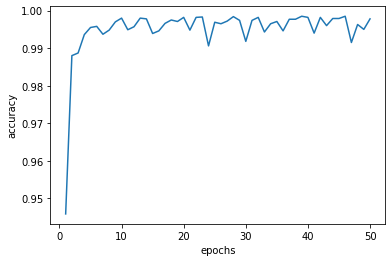

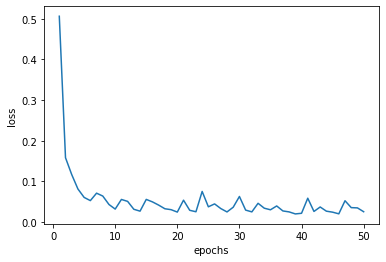

In [672]:
nn.train(EPOCHS, BATCH_SIZE)

Save the model for use in the website:

In [806]:
nn.model.save('./model.h5')

### Predictions

You cand try to predict by your own on the interactive website, following the link: